# Ligo Primary Analysis

* Tested on Intel based Linux. 
* Notebook issue with it being too large to save with renders. Hence PDF screenshot will be provided. Request to run the notebook for visuals in the jupyter enviornment. The file is in the same folder called: ligo_primary_analysis_notebook.pdf and contains the rendered version of this file.
* Notebook may take a while to render. This is partly due to graphic processing, and also due to the fact this code was not performance optimized. Please be patient (we've seen 15-20 minutes) for the full render.
* Installation instructions to notebook on the README
* python -m pip install -r requirements_primary.txt for installing the relevant libs

# 0. Imports

In [6]:
import logging
import h5py
import json
import inspect
import readligo as rl
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import numpy as np
from gwosc.locate import get_urls
import requests
import os
from gwosc.locate import get_urls
from scipy import signal
from gwpy.timeseries import TimeSeries

logger = logging.getLogger()
logger.setLevel(logging.INFO)

from rk_visualizer import *
app = RKModelApplication(master=root)
visualizer = RKGraphVisualizer(app)

In [5]:
# Uncomment this section if using on a server w/o a display!

#import os
#os.system("Xvfb :1 -screen 0 720x720x16 &")
#os.environ['DISPLAY'] = ":1.0"

# 1. Read LIGO Strain Data & Load for Analysis

In [7]:
detector = 'H1'
event_data  = {'GW170729': {'t': 1185389807.3},
               'GW170817': {'t': 1187008882.4},
               'GW190521': {'t': 1242442967.4},
               'GW190814': {'t': 1249852257.0}}

for name, event in event_data.items():
    url = get_urls(detector, event['t'], event['t'])[-1]
    fn = os.path.basename(url)
    n = url.split("/")[-3]
    event_data[n]["path"] = fn
    if not os.path.exists(fn): 
        print('Downloading: ' , url)
        with open(fn,'wb') as strainfile: 
            straindata = requests.get(url)
            strainfile.write(straindata.content)
    else:
        print("already downloaded {}. skipping".format(fn))
        
# using the tool
visualizer.load_data()
print(inspect.getsource(visualizer.load_data))

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170729/v1/H-H1_GWOSC_4KHZ_R1-1185387760-4096.hdf5
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170817/v3/H-H1_GWOSC_4KHZ_R1-1187006835-4096.hdf5
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-2.1-confident/GW190521/v4/H-H1_GWOSC_4KHZ_R1-1242440920-4096.hdf5
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-2.1-confident/GW190814/v3/H-H1_GWOSC_4KHZ_R1-1249850209-4096.hdf5
Trying to find event for 1185389807.3: https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170729/v1/H-H1_GWOSC_4KHZ_R1-1185387760-4096.hdf5
GW170729 is already downloaded
Trying to find event for 1187008882.43: https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170817/v3/H-H1_GWOSC_4KHZ_R1-1187006835-4096.hdf5
GW170817 is already downloaded
Trying to find event for 1242442967.4: https://www.gw-openscience.org/eventapi/json/GWTC-2.1-confident/GW190521/v4/

# 2. View Strain Data in Time Series

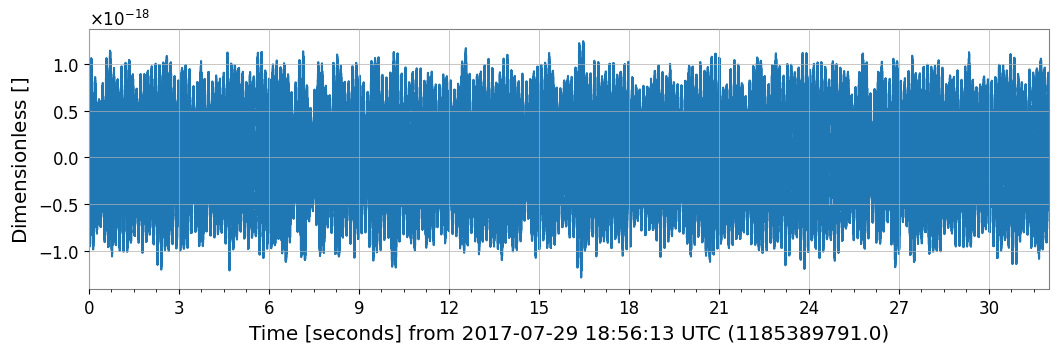

In [8]:
focus_event = 'GW170729'
strain = TimeSeries.read(event_data[focus_event]['path'],format='hdf5.losc')
center = int(event_data['GW170729']['t'])
strain = strain.crop(center-16, center+16)
fig1 = strain.plot()

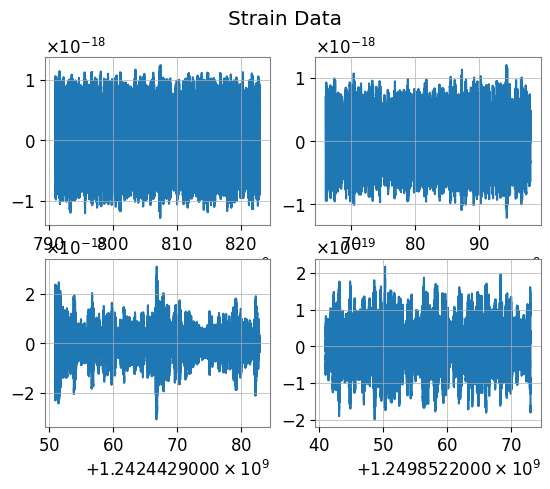

    def plot_strain(self):
        figure = plt.gcf()
        figure.clf()
        figure.add_subplot(221)
        figure.add_subplot(222)
        figure.add_subplot(223)
        figure.add_subplot(224)
        axes = figure.get_axes()
        count=0
        figure.suptitle("Strain Data")
        for k,f in event_names.items():
            row = math.floor(count/2)
            col = count%2
            fn = f['file']
            if fn == "":
                return
            strain = self.get_strain(fn, f['ts'])
            axes[count].plot(strain)
            count+=1
        plt.show()



In [9]:
visualizer.plot_strain()
print(inspect.getsource(visualizer.plot_strain))

# 3. Plot ASD of Whitened & Band-Passed Strain

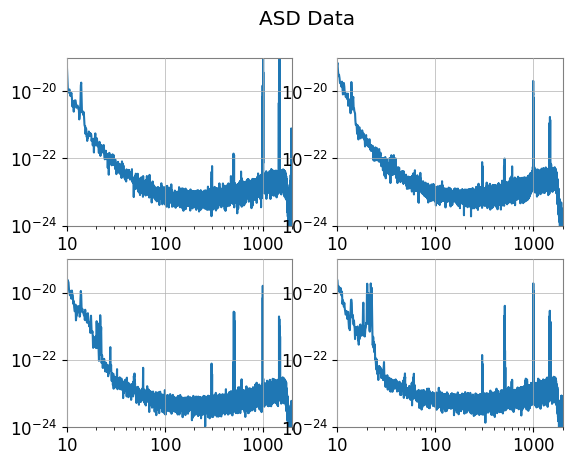

    def plot_asd(self):
        figure = plt.gcf()
        figure.clf()
        figure.add_subplot(221)
        figure.add_subplot(222)
        figure.add_subplot(223)
        figure.add_subplot(224)
        axes = figure.get_axes()
        count=0
        figure.suptitle("ASD Data")
        for k,f in event_names.items():
            ax = axes[count]

            fn = f['file']
            if fn == "":
                return

            strain = self.get_strain(fn, f['ts'])
            f2 = strain.asd(fftlength=8)
            ax.plot(f2)
            ax.set_xlim(10,2000)
            ax.set_ylim(1e-24, 1e-19)
            ax.set_yscale('log')
            ax.set_xscale('log')
            count+=1
        plt.show()



In [10]:
visualizer.plot_asd()
print(inspect.getsource(visualizer.plot_asd))

# 4. Plot Multi-event Spectograms 

/home/andor/miniconda3/lib/python3.9/site-packages/gwpy/plot/axes.py:308: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return super().pcolormesh(*args, **kwargs)


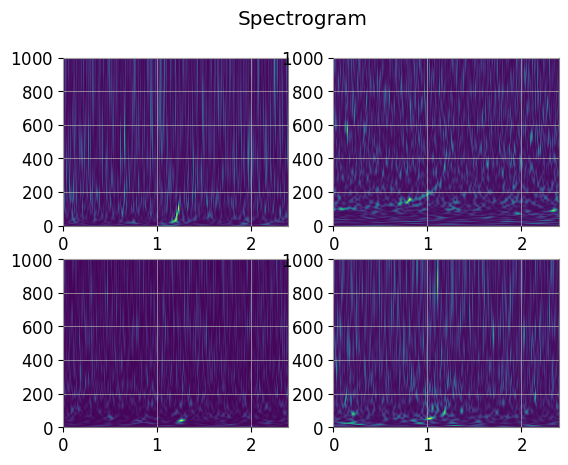

    def plot_spectrograms(self):
        figure = plt.gcf()
        figure.clf()
        figure.add_subplot(221)
        figure.add_subplot(222)
        figure.add_subplot(223)
        figure.add_subplot(224)
        axes = figure.get_axes()
        count=0
        figure.suptitle("Spectrogram")
        for k,f in event_names.items():
            ax = axes[count]
            fn = f['file']
            if fn == "":
                return
            t0 = f['ts']
            strain = self.get_strain(fn, f['ts'])
            dt = 1  #-- Set width of q-transform plot, in seconds
            hq = strain.q_transform(outseg=(t0-dt, t0+dt))
            ax.pcolormesh(np.linspace(0,2.4,hq.shape[0]), np.linspace(0,1000,hq.shape[1]), hq.T)
            count+=1
        plt.show()



In [11]:
visualizer.plot_spectrograms()
print(inspect.getsource(visualizer.plot_spectrograms))

# 5. Merge Events in Frequency & Time Space and Unfiltered Topological Eventscape in 3D

/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticksl)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticksl)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


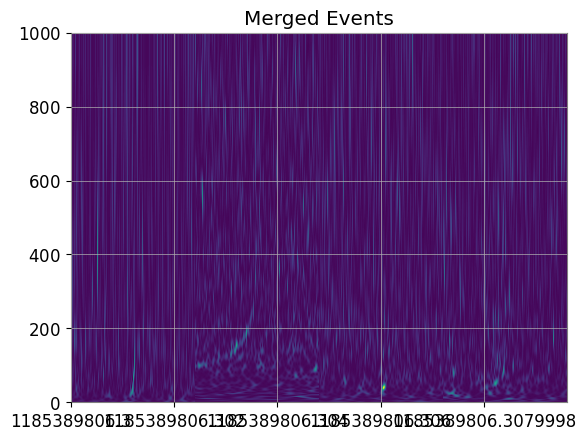

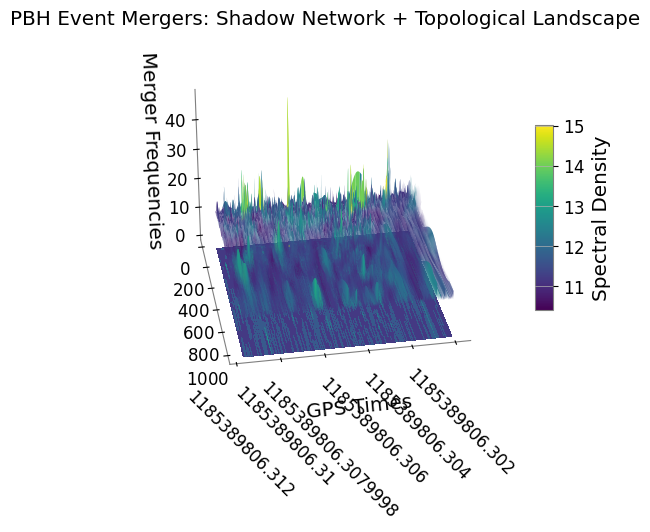

    def plot_eventscape(self):
        count=0

        xticksl = []
        dt=3
        full_eventscape = []

        for k,f in event_names.items():
            fn = f['file']
            strain = self.get_strain(fn, f['ts'])
            dt = 1
            t0 = f['ts']
            hq = strain.q_transform(outseg=(t0-dt, t0+dt))
            xticksl.extend(hq.xindex.to_value())
            if len(full_eventscape) == 0:
                full_eventscape = np.array(hq)
            else:
                full_eventscape = np.concatenate([full_eventscape, np.array(hq)])

        xticks = np.linspace(0,2.4, 4000)
        yticks = np.linspace(0,1000, 2560)
        fig, ax = plt.subplots()
        ax.pcolormesh(xticks, yticks, full_eventscape.T)
        ax.set_xticklabels(xticksl)
        ax.set_title("Merged Events")

        fig = plt.figure(dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        H = full_eventscape.T
        cmap='viridis'
        X, Y = np.meshgrid(xticks, yticks

In [12]:
visualizer.plot_eventscape()
print(inspect.getsource(visualizer.plot_eventscape))

# 6 Filtered Topological Eventscape in 3D with Projected Events in 2D

/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:210: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticksl)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticksl)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:242: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


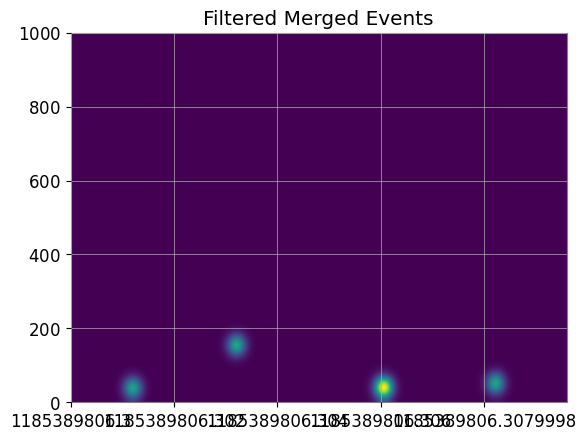

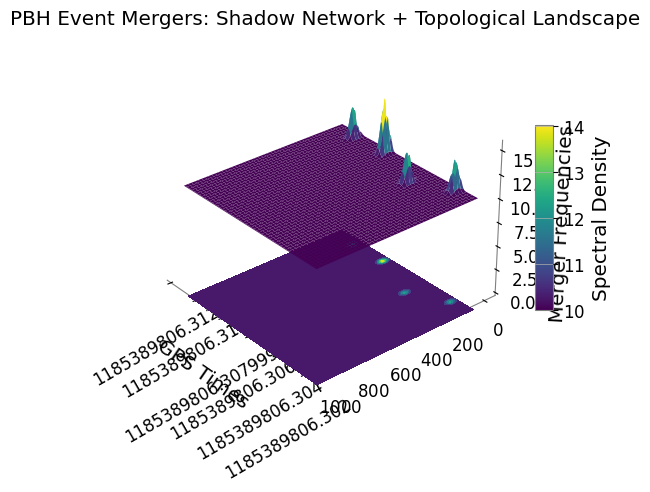

    def plot_filteredscape(self):
        count=0

        xticksl = []
        dt=3
        full_eventscape = []

        for k,f in event_names.items():
            fn = f['file']
            strain = self.get_strain(fn, f['ts'])
            dt = 1
            t0 = f['ts']
            hq = strain.q_transform(outseg=(t0-dt, t0+dt))
            hq[hq < hq.max()] = 0
            xticksl.extend(hq.xindex.to_value())
            if len(full_eventscape) == 0:
                full_eventscape = np.array(hq)
            else:
                full_eventscape = np.concatenate([full_eventscape, np.array(hq)])

        from scipy.ndimage import gaussian_filter, maximum_filter
        H = full_eventscape.T
        H = maximum_filter(H, size=50)
        H = gaussian_filter(H, sigma=50)

        xticks = np.linspace(0,2.4, 4000)
        yticks = np.linspace(0,1000, 2560)
        fig, ax = plt.subplots()
        ax.pcolormesh(xticks, yticks, H)
        ax.set_xticklabels(xticksl)
        ax.set_title

In [13]:
visualizer.plot_filteredscape()
print(inspect.getsource(visualizer.plot_filteredscape))

# 7. Omniview of All Paramenter Estimate from Best Fit Model in Pair Plots

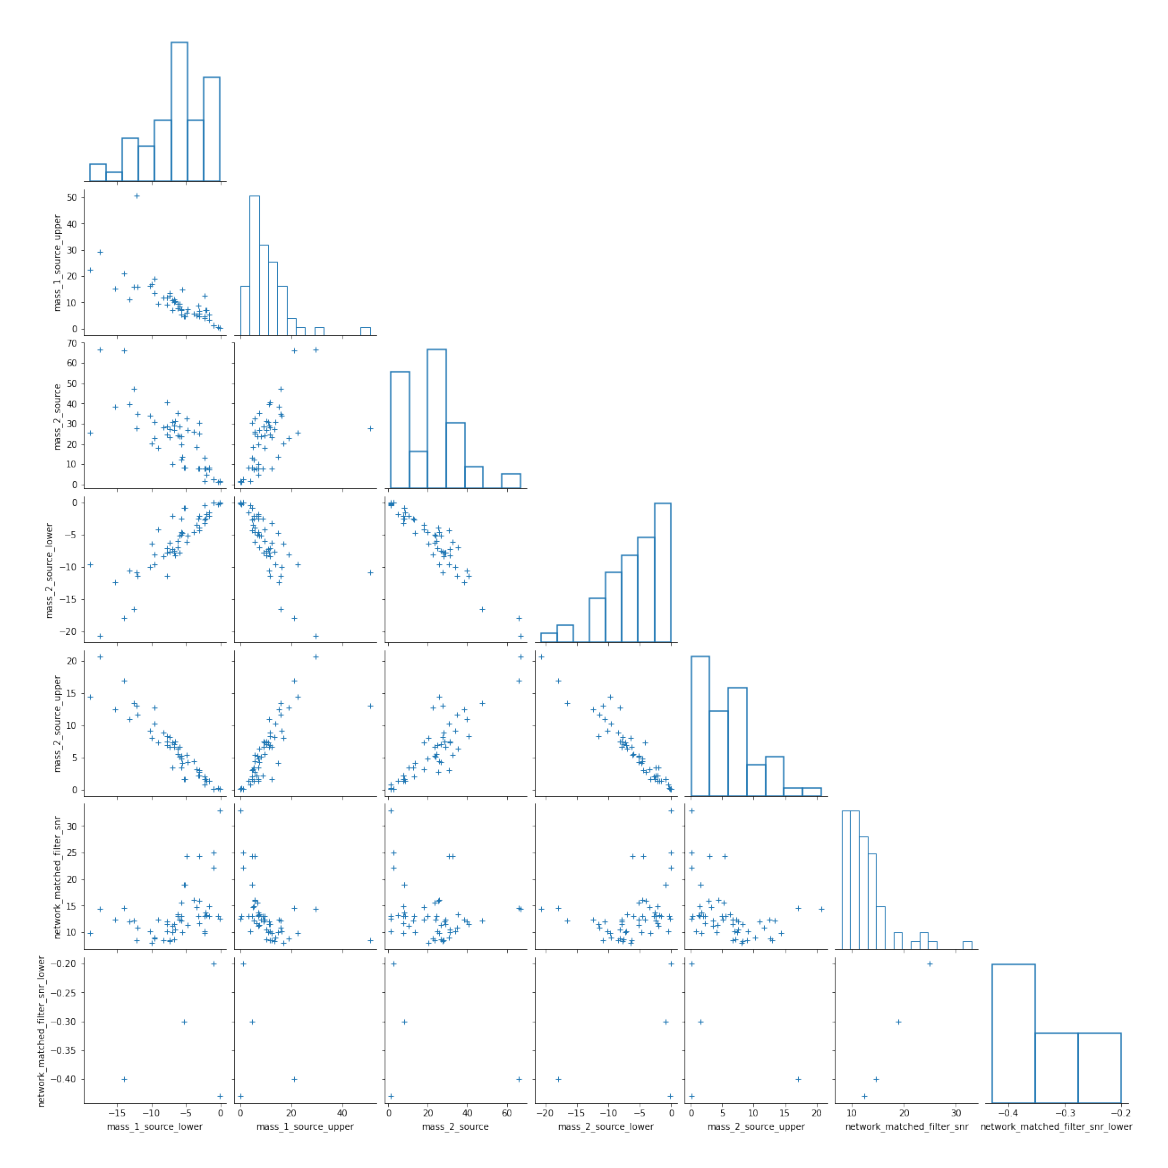

    def plot_pair_plots(self):
        '''
        plot secondary measures
        '''
        #import seaborn as sns
        #j
        #df = pd.read_csv("ligo_events.csv")
        #sns.pairplot(df.iloc[:,8:15], dropna=True, corner=True,     plot_kws=dict(marker="+", linewidth=1),  diag_kws=dict(fill=False))
        fig, ax = plt.subplots(dpi=300)
        img = plt.imread("pairplot.png")
        ax.imshow(img)
        ax.axis('off')
        plt.show()



In [15]:
visualizer.plot_pair_plots()
print(inspect.getsource(visualizer.plot_pair_plots))

# 8. Plot Graph hierarchy for independent PE variable Clusters

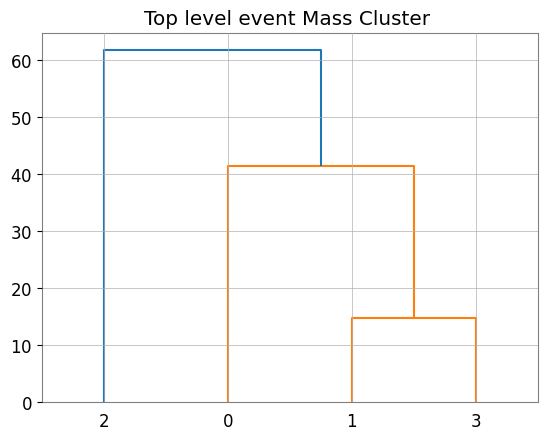

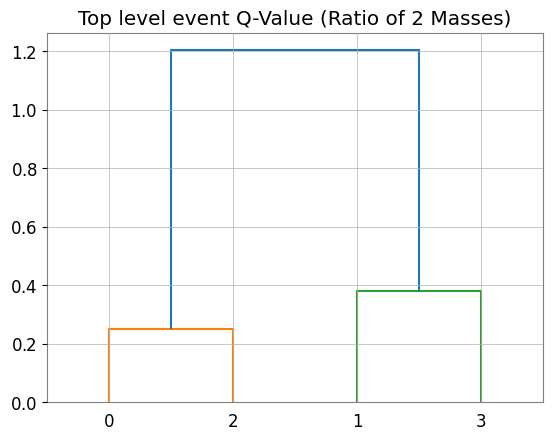

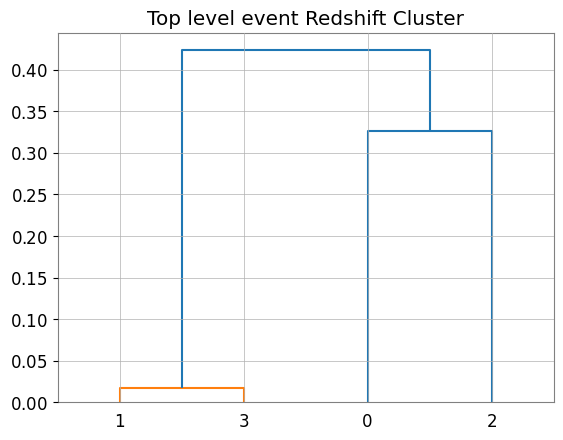

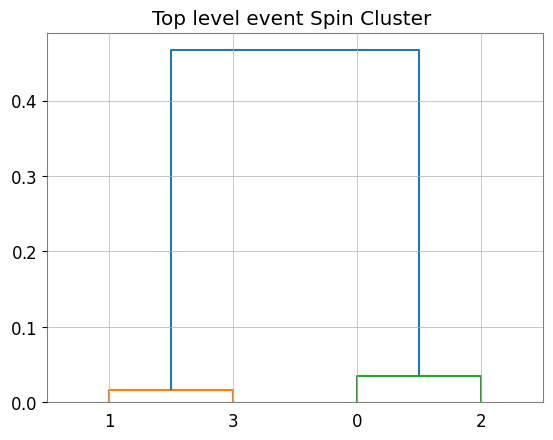

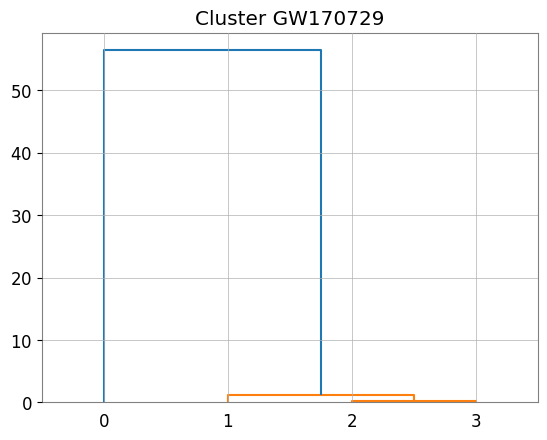

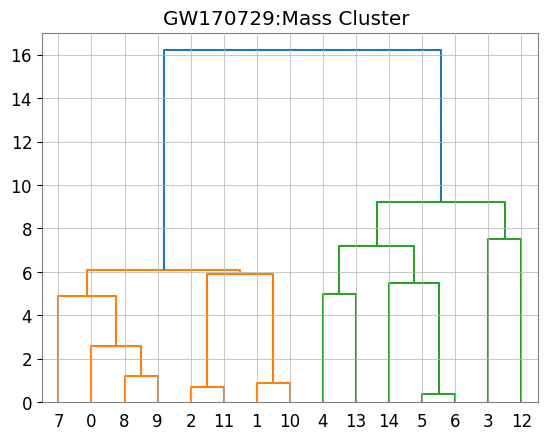

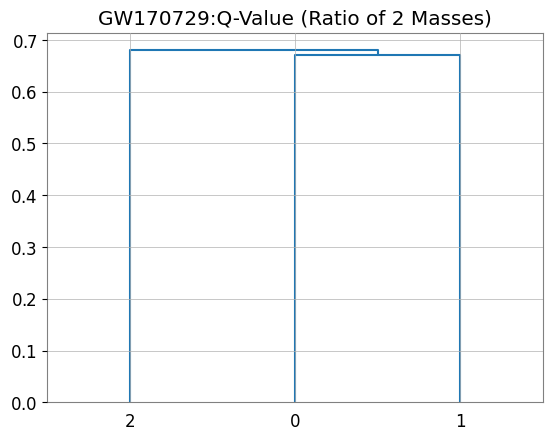

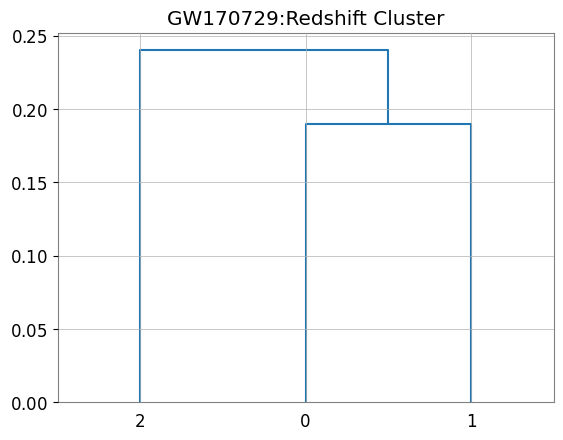

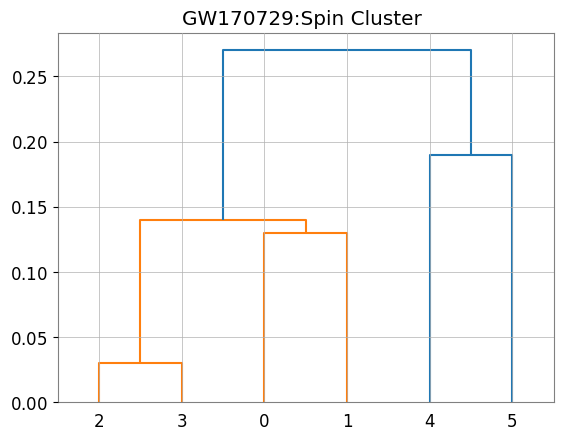

    def plot_heirarchy(self):
        from scipy.cluster.hierarchy import dendrogram, linkage
        from matplotlib import pyplot as plt
        df = pd.read_csv("ligo_classifications2.csv")

        for i, g in df.groupby('Name of Cluster'):
            X = []
            for j, cluster in g.groupby('Event name '):
                X.append([cluster['Value of Each Node'].mean()])
            Z = linkage(X, 'single')
            fig,ax = plt.subplots()
            dn = dendrogram(Z)
            ax.set_title("Top level event {}".format(i))

        for i, g in df.groupby('Event name '):
            X = []
            for j, cluster in g.groupby('Name of Cluster'):
                X.append([cluster['Value of Each Node'].mean()])
            Z = linkage(X, 'single')
            fig, ax = plt.subplots()
            dn = dendrogram(Z)
            ax.set_title("Cluster {}".format(i))
            for j, cluster in g.groupby('Name of Cluster'):
                X2 = []
                for _, n

In [16]:
visualizer.plot_heirarchy()
print(inspect.getsource(visualizer.plot_heirarchy))

# 9. Building RK Models from Hierarchy

/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:389: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
No handles with labels found to put in legend.


Adding node to cluster Mass 1 (Ma1)_0:c79cb20b-f014-4667-a569-4a8d816b2782
Adding node to cluster Mass 1 (Ma2) _0:995844e6-ca7a-40ce-84fd-f8334d0efe7f
Adding node to cluster Mass 1 (Ma3) _0:792bde10-a8b1-4002-8964-e9717c8c7bc4
Adding node to cluster Mass 2 (Mb1)_0:82d7ef10-8386-4513-b1b7-d4c267baa765
Adding node to cluster Mass 2 (Mb2)_0:eaeb1f25-56e5-4f61-a77f-c65c079e8ee3
Adding node to cluster Mass 2 (Mb3)_0:c664f89d-3f26-4705-88b9-7ef361b0262b
Adding node to cluster Total Mass (TM1)_0:98df2b0a-b29f-4b06-8c3e-21e4cb8041f8
Adding node to cluster Total Mass (TM2)_0:526e37de-8466-43c4-b952-4d6e0b87ff6e
Adding node to cluster Total Mass (TM3)_0:0760db2d-3659-40fb-bfc0-0e3e1c0aa135
Adding node to cluster Chirp Mass (CM1)_0:e49df058-7772-4804-ab84-5e44f9ce822c
Adding node to cluster Chirp Mass (CM2)_0:85fee874-3d2a-43ab-a514-d53b0fe9fac9
Adding node to cluster Chirp Mass (CM3)_0:d2152f07-07ee-4628-9b22-a827cab2e4bd
Adding node to cluster Final Mass (FM1)_0:655987f4-11d0-499a-afb8-3d43763d

Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:424: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/and

Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:171: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax2 = Axes3D(fig)

Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:424: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/and

Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:171: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax2 = Axes3D(fig)

Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:424: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(dpi=100)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/r

Drawing 105 edges for 15 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:171: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax2 = Axes3D(fig)

Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:424: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/and

Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:156: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax = Axes3D(fig)
/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:171: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  minor_ax2 = Axes3D(fig)

Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:345: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


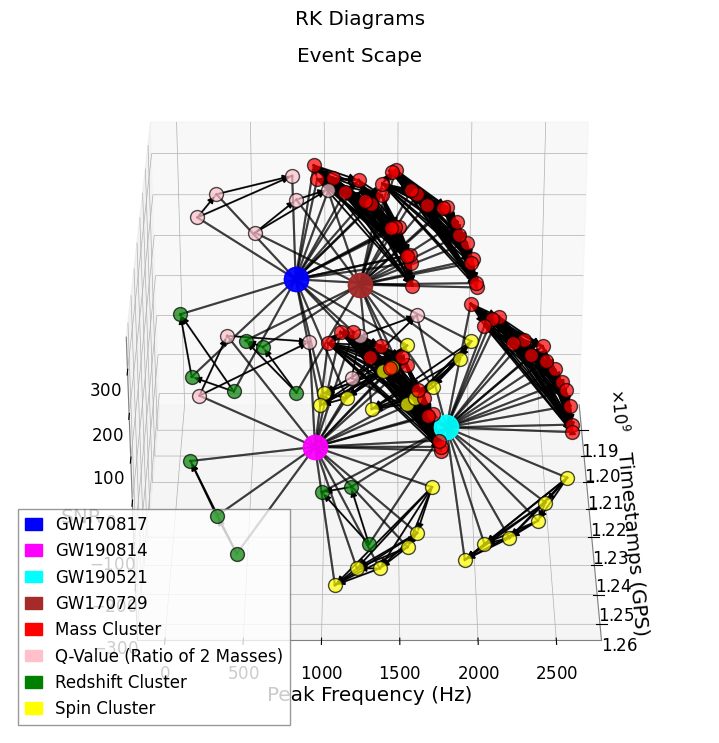

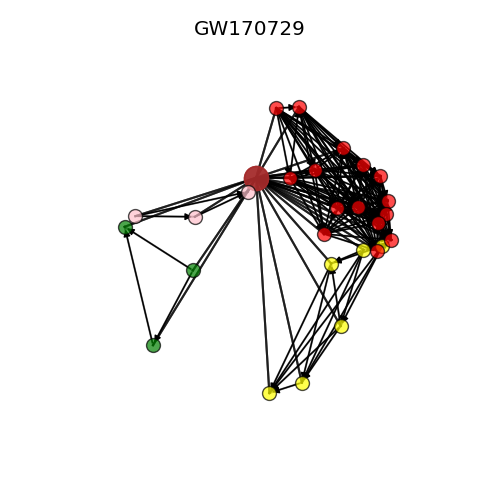

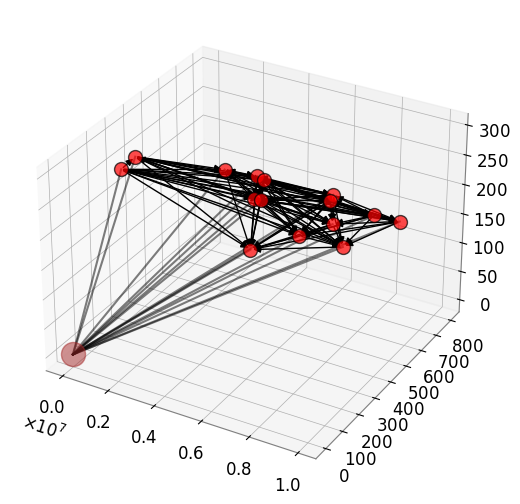

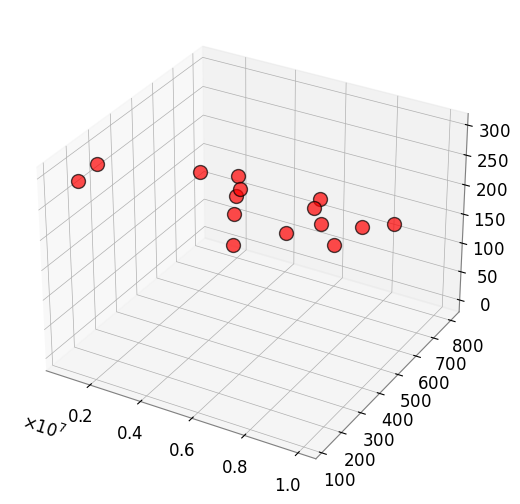

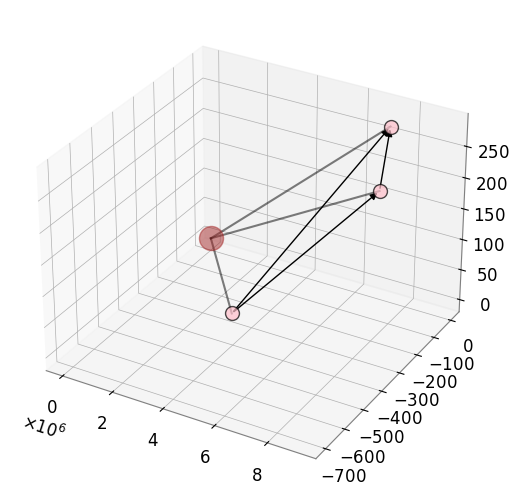

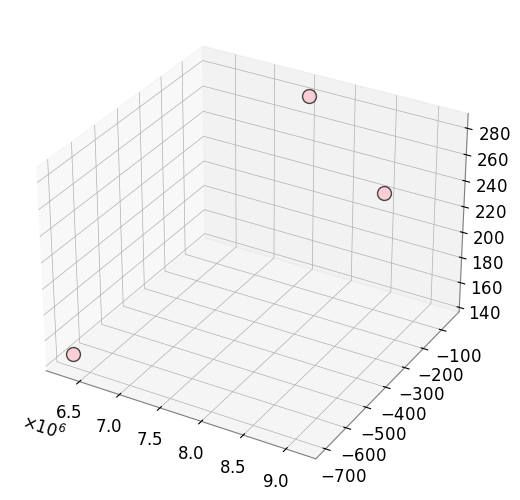

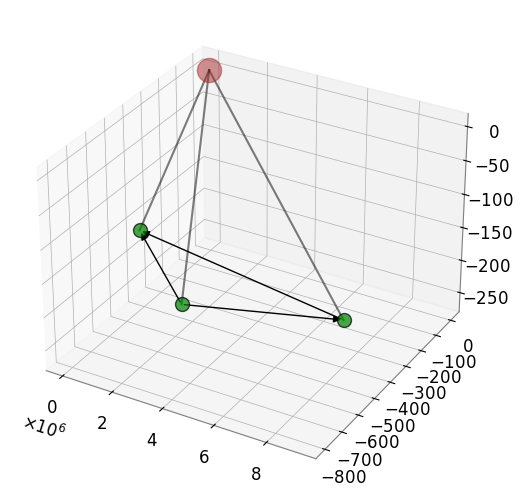

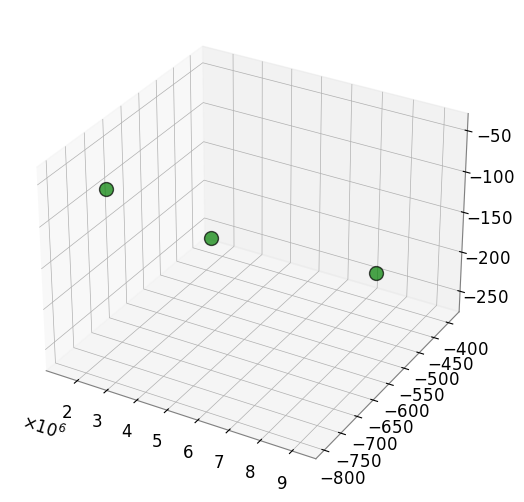

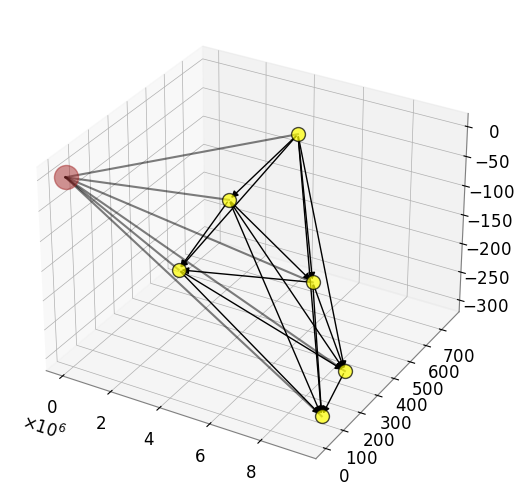

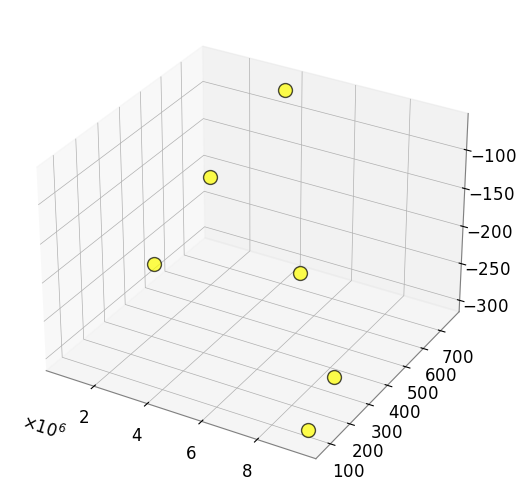

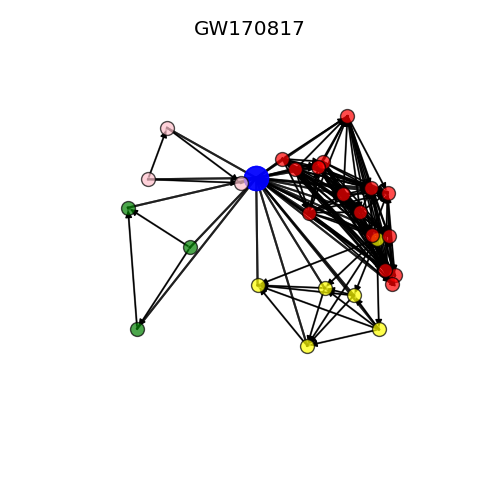

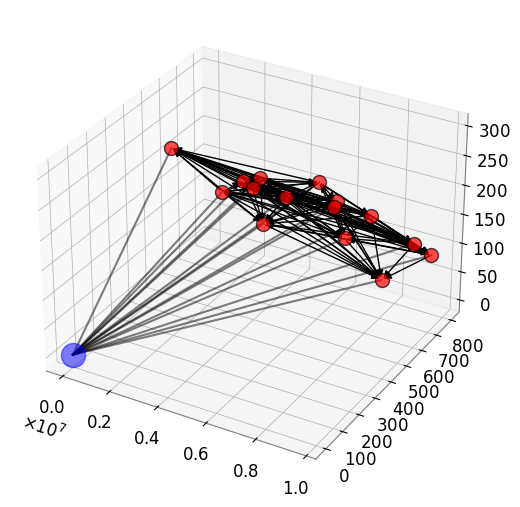

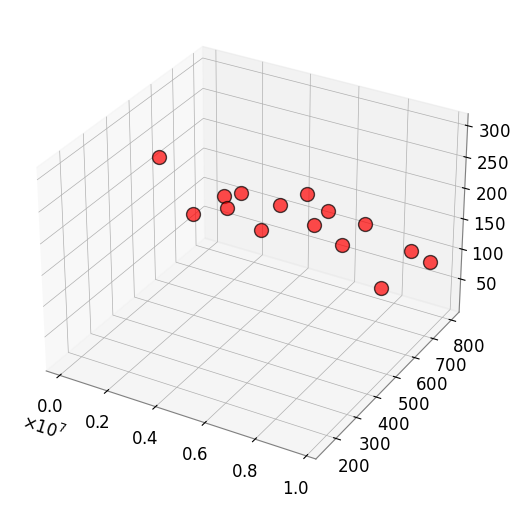

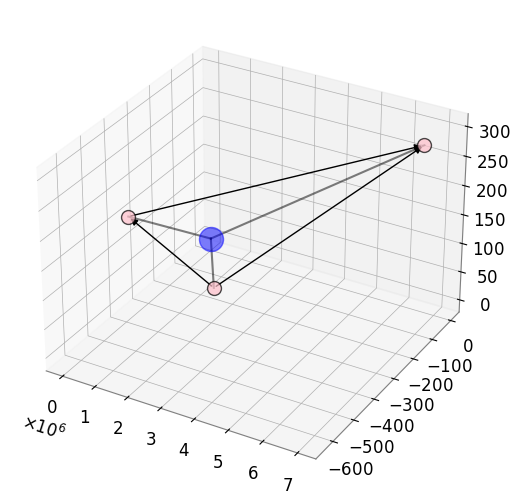

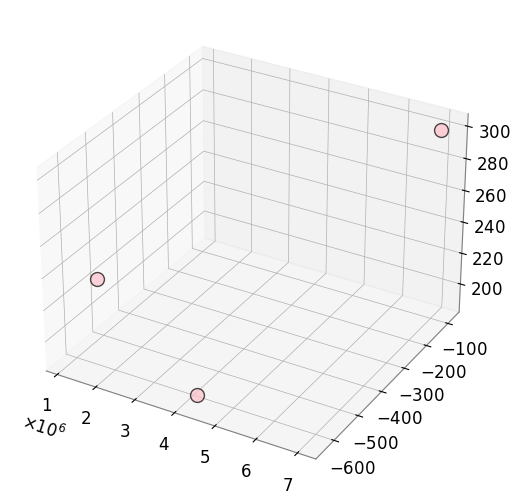

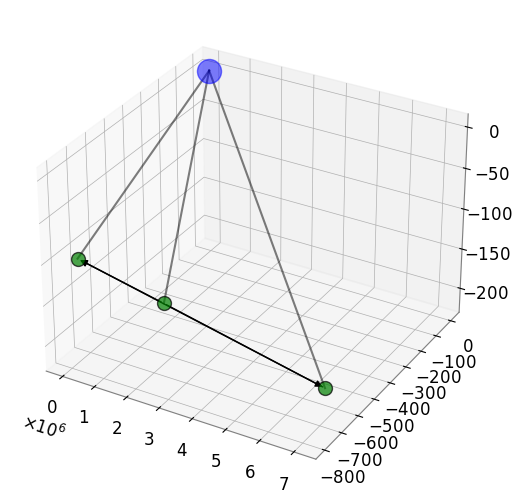

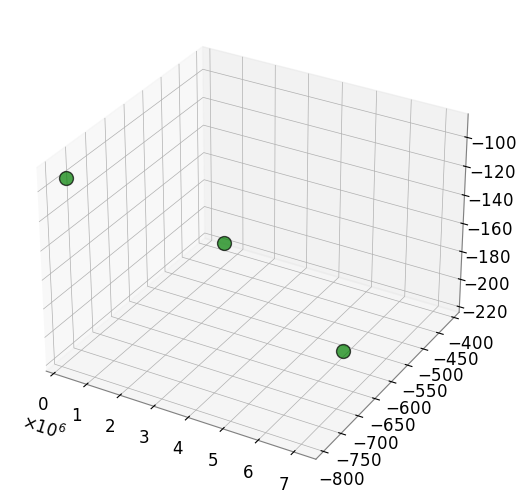

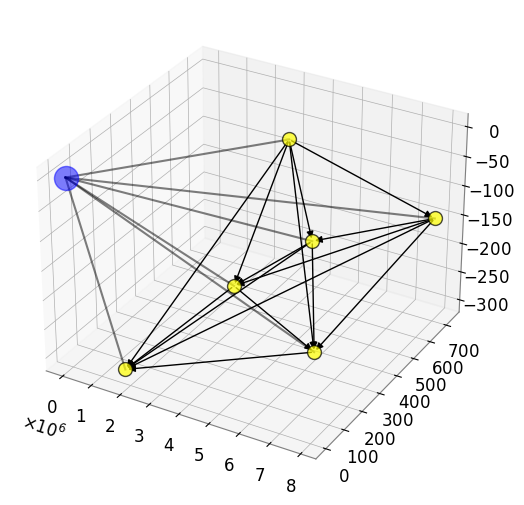

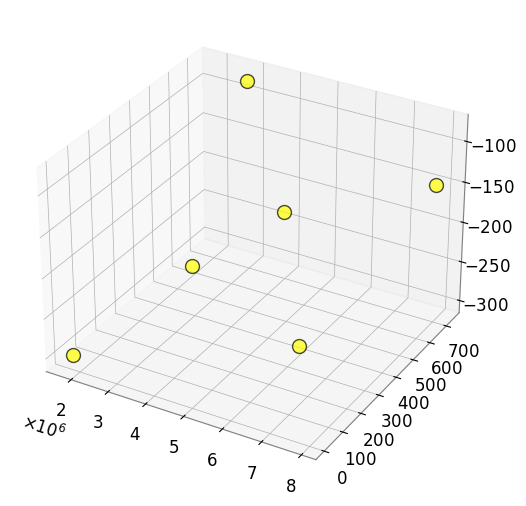

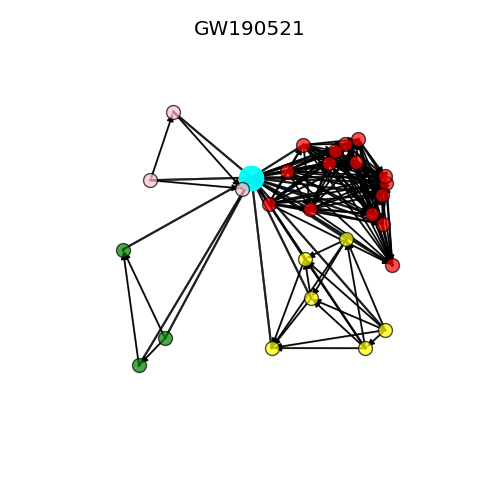

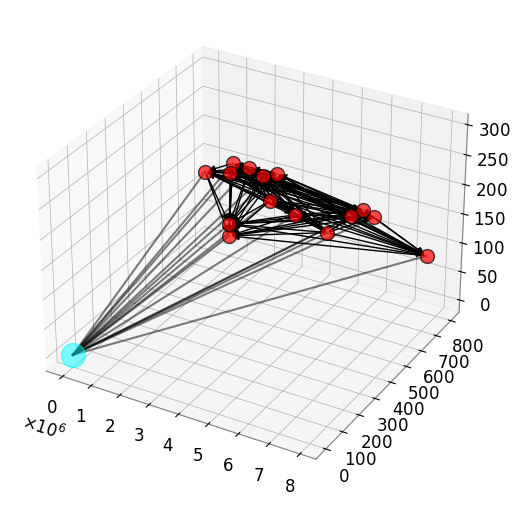

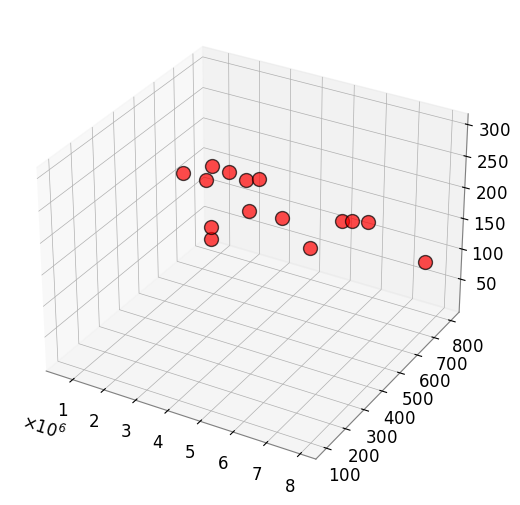

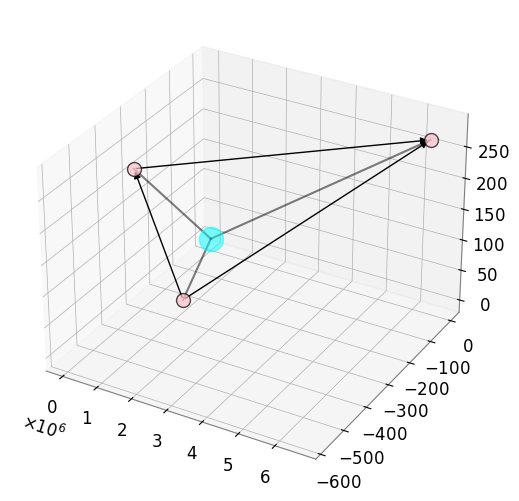

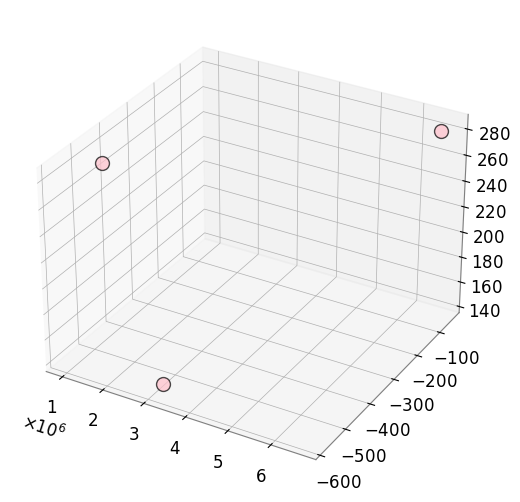

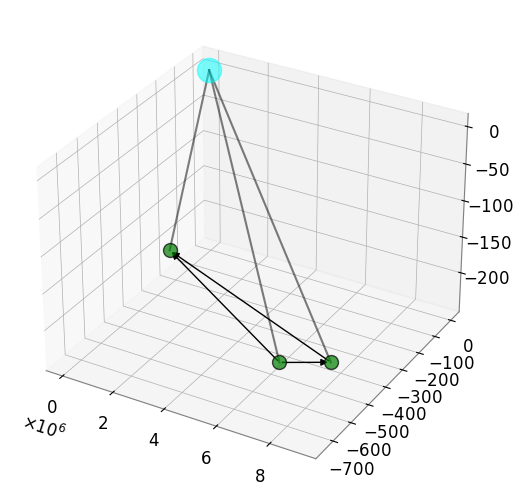

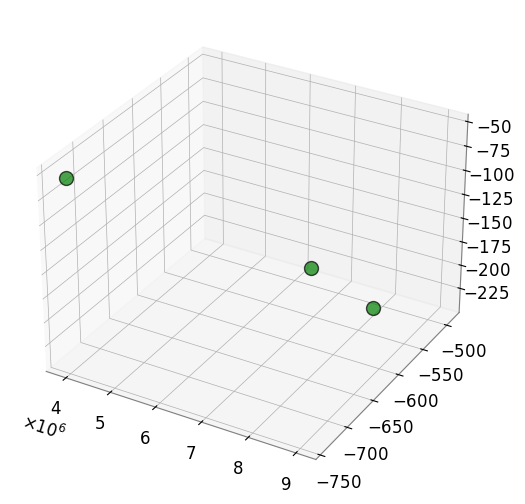

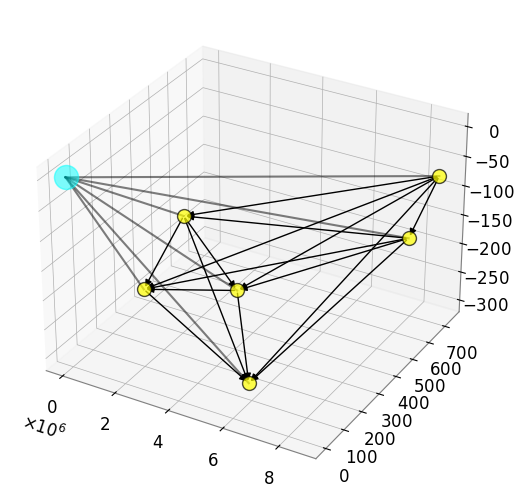

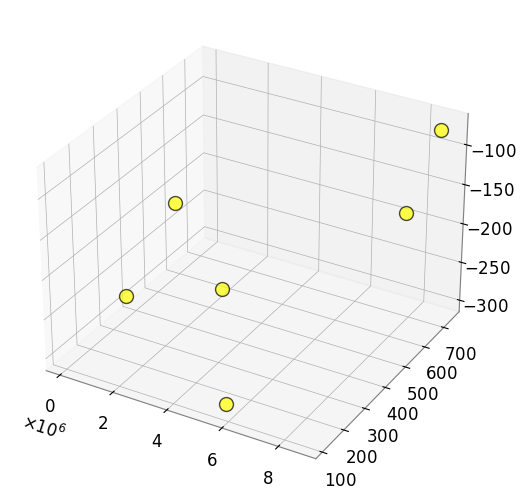

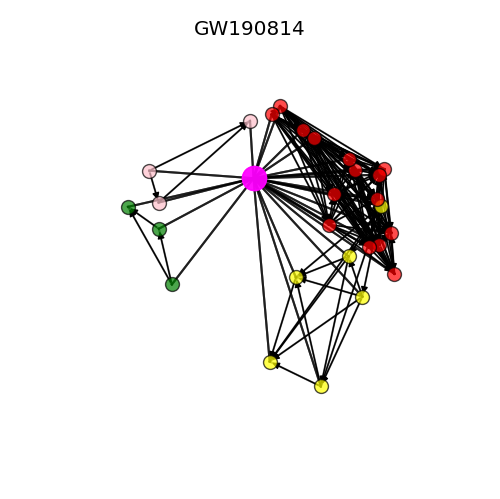

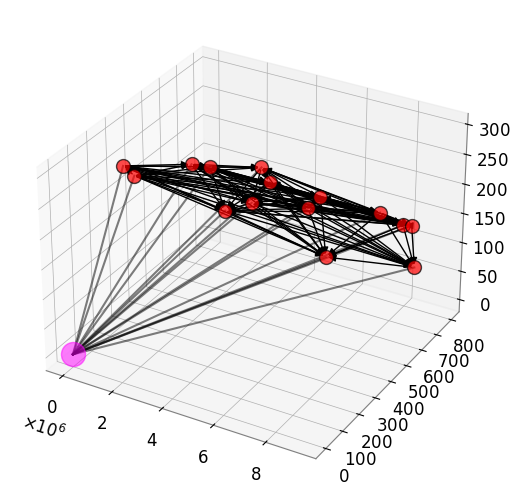

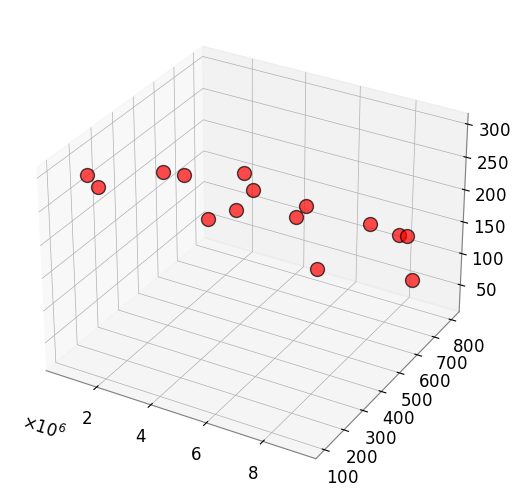

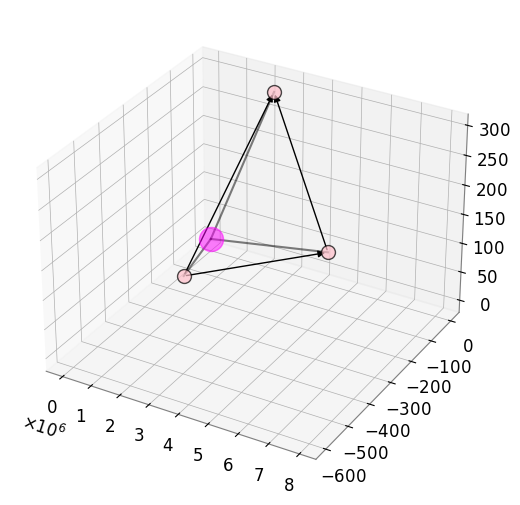

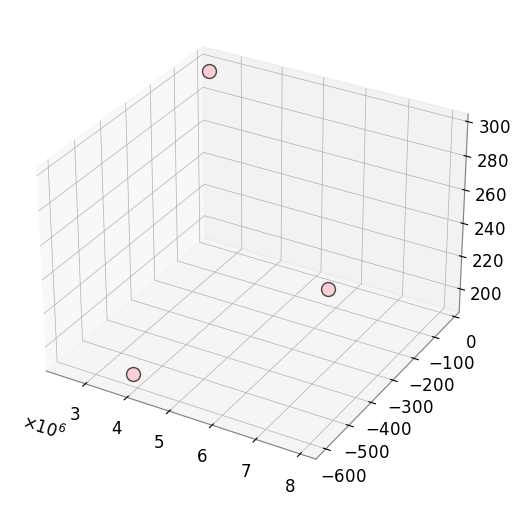

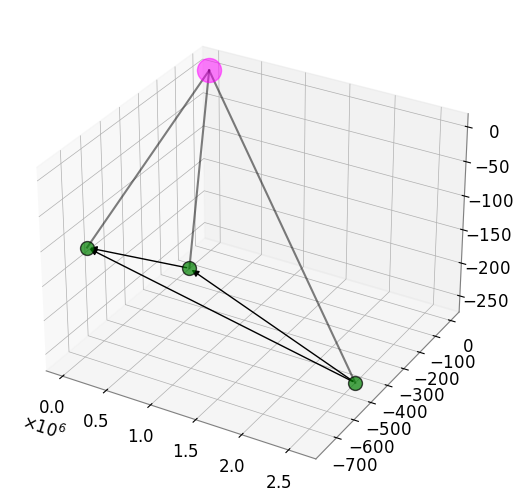

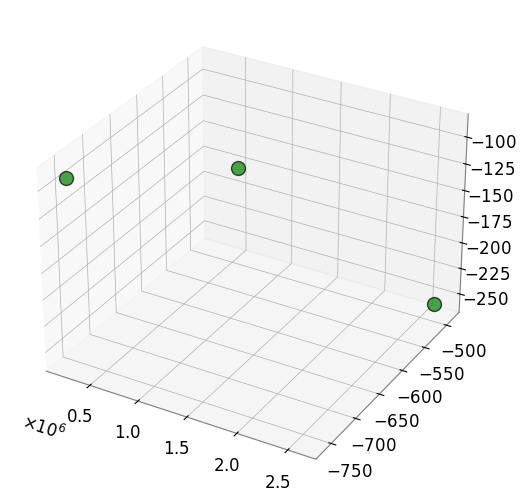

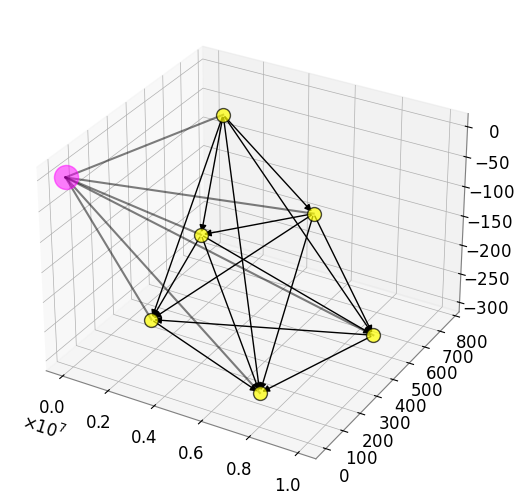

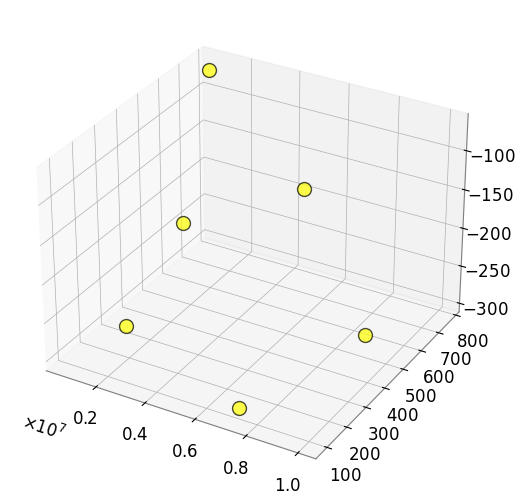

    def plot_network(self):
        df = pd.read_csv("ligo_classifications2.csv")
        event_info = {
            'GW170817': {'ts': 1187008882,
                         'pf': 800,
                         'snr': 33.2},
            'GW190814': {'ts': 1249852257,
                         'pf': 960,
                         'snr': 25.6},
            'GW190521': {'ts': 1242442967,
                         'pf': 1800,
                         'snr': 22.4},
            'GW170729': {'ts': 1185389807,
                         'pf': 1240,
                         'snr':10.2
            }
        }

        model = EventScape()
        for event_name, eventdf in df.groupby('Event name '):

            event = RKEvent(name=event_name, attributes=event_info[event_name])
            model.add_event(event)

            for cluster_name, clusterdf in eventdf.groupby('Name of Cluster'):

                rk_cluster = RKCluster(name=event_name)
                event.add_cluster(rk_cluster)
         

In [17]:
visualizer.plot_network()
print(inspect.getsource(visualizer.plot_network))

# 10 Apply Linkers and Filters to the R-K Model and Plot Final R-K Diagrams

/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:567: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
No handles with labels found to put in legend.


Adding node to cluster Mass 1 (Ma1)_0:b70a766a-e1a9-4da5-9fd4-0b302c2247b6
Adding node to cluster Mass 1 (Ma2) _0:b7820e49-77cb-424d-ba1a-4fbbbb15aeea
Adding node to cluster Mass 1 (Ma3) _0:e9e1e63d-b25e-4dfb-9a94-0f974dc31c89
Adding node to cluster Mass 2 (Mb1)_0:95c5cafd-6814-4883-a208-f140600ef320
Adding node to cluster Mass 2 (Mb2)_0:15d94b58-8300-4ed3-b4c5-7052a54e0225
Adding node to cluster Mass 2 (Mb3)_0:a298a33b-eafa-47f8-8485-23666c32a142
Adding node to cluster Total Mass (TM1)_0:84133052-6169-459b-b988-f296b4f66680
Adding node to cluster Total Mass (TM2)_0:eb15d18e-8f9e-4b97-8d04-954feb40b9b4
Adding node to cluster Total Mass (TM3)_0:b2ae692a-9531-43f0-b5ce-3fd809c8258f
Adding node to cluster Chirp Mass (CM1)_0:c8384fcb-7839-492e-80e4-7c18fcf08f0e
Adding node to cluster Chirp Mass (CM2)_0:0de15a30-1d5d-43d6-a0c3-3d66692304d8
Adding node to cluster Chirp Mass (CM3)_0:d4351118-7508-4ed8-a393-fd0660b5eb17
Adding node to cluster Final Mass (FM1)_0:36c19b50-0133-421f-be36-95c6a13a

Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes
Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:602: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:602: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:602: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rk_visualizer.py:602: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Drawing 105 edges for 15 nodes
Drew 105 edges for 15 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 3 edges for 3 nodes
Drew 3 edges for 3 nodes
Drawing 15 edges for 6 nodes
Drew 15 edges for 6 nodes


/home/andor/workspace/github.com/andorsk/rk_toolkit_pipeline_diagrams/02_notebooks/rk_gw_mma/rkmodel/rkmodels.py:345: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


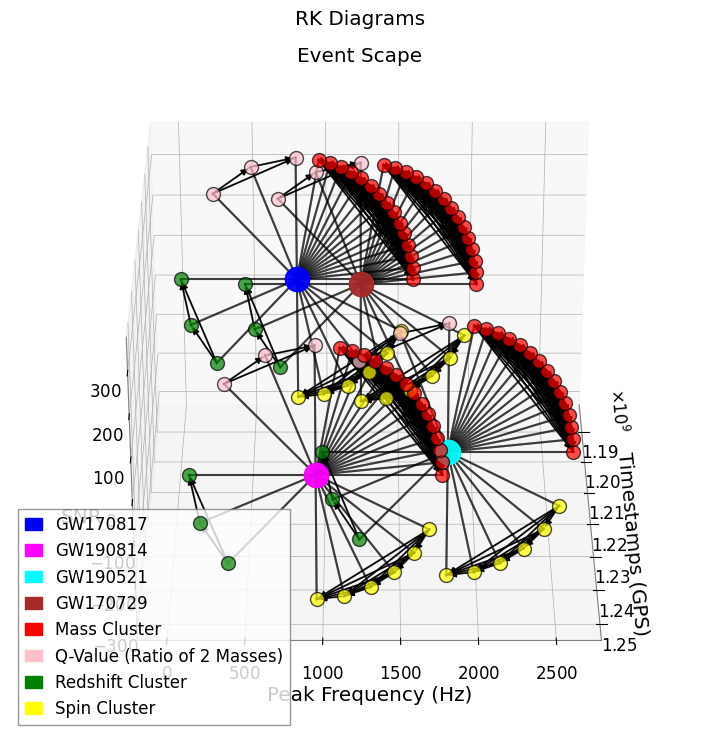

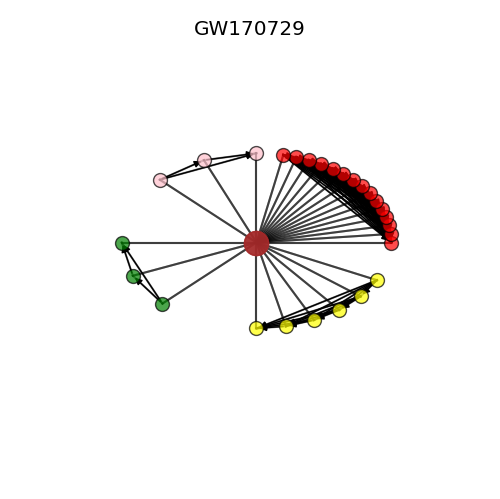

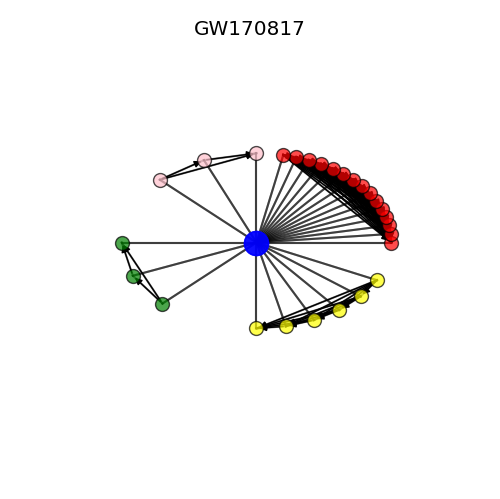

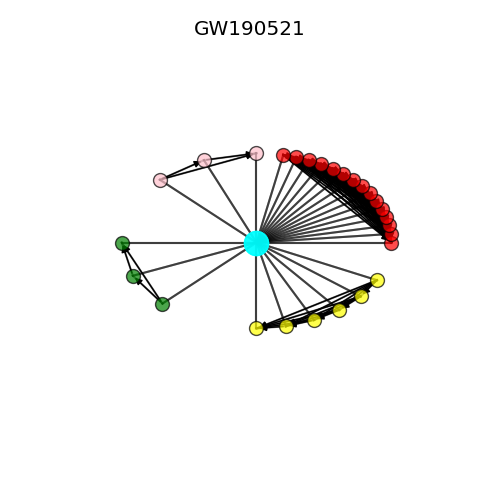

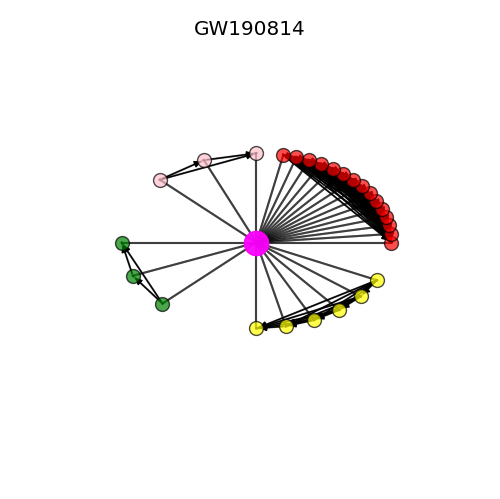

    def plot_rk_diagrams(self):

        df = pd.read_csv("ligo_classifications2.csv")
        event_info = {
            'GW170817': {'ts': 1187008882,
                         'pf': 800,
                         'snr': 33.2},
            'GW190814': {'ts': 1249852257,
                         'pf': 960,
                         'snr': 25.6},
            'GW190521': {'ts': 1242442967,
                         'pf': 1800,
                         'snr': 22.4},
            'GW170729': {'ts': 1185389807,
                         'pf': 1240,
                         'snr':10.2
            }
        }

        model = EventScape()
        for event_name, eventdf in df.groupby('Event name '):

            event = RKEvent(name=event_name, attributes=event_info[event_name])
            model.add_event(event)

            for cluster_name, clusterdf in eventdf.groupby('Name of Cluster'):

                rk_cluster = RKCluster(name=event_name)
                event.add_cluster(rk_cluster)
    

In [18]:
visualizer.plot_rk_diagrams()
print(inspect.getsource(visualizer.plot_rk_diagrams))